<a href="https://colab.research.google.com/github/eduardoplima/rl-imd/blob/main/Q_learning_SARSA_NN_PyTorch_CartPole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Q-learning and SARSA with neural network for Cart Pole (PyTorch)

In this notebook, we will use Q-learning and SARSA with neural network to solve Cart Pole.


Environment: (https://gymnasium.farama.org/environments/classic_control/cart_pole/).

##Setup

In [ ]:
%%capture
!pip install gymnasium
!pip install numpy
!pip install imageio imageio_ffmpeg
!pip install pyvirtualdisplay
!apt-get install -y xvfb
!apt-get install -y python-opengl ffmpeg
!pip install pytorch

In [ ]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
# Importing PyTorch neural network (torch.nn) and optimizer (torch.optim)
import torch
import torch.nn as nn
import torch.optim as optim

## Setup a Virtual Display
To generate a replay video of agent and environment.

In [ ]:
# Virtual display
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

In [ ]:
# Let's start by creating the Cart Pole environment.
env = gym.make("CartPole-v1", render_mode="rgb_array")
env.spec

EnvSpec(id='CartPole-v1', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, disable_env_checker=False, kwargs={'render_mode': 'rgb_array'}, namespace=None, name='CartPole', version=1, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv')

##Observing the environment

In [ ]:
# actions: push cart to the left=0, push cart to the right = 1
actions = ["push cart to the left", "push cart to the right"]
print ("Actions:", actions)

Actions: ['push cart to the left', 'push cart to the right']


In [ ]:
def plot_image(plot, render, size):
  plot.figure(figsize=(14, 5))
  plot.xticks(range(size))
  plot.yticks(range(size))
  plot.imshow(render, extent=[0, size, size, 0])
  plot.show()

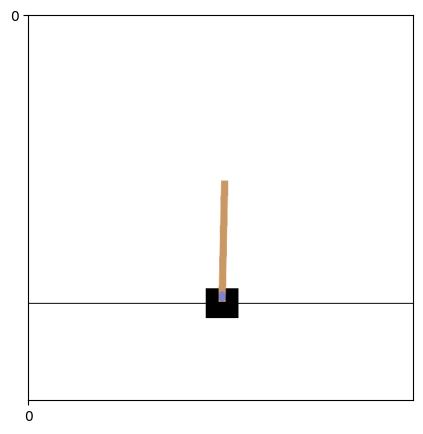

In [ ]:
# This sets the initial state at S, our starting point
# We can render the environment to see where we are on the cart pole environment
env.reset()
img = env.render()
plot_image(plt,img,1)

##Executing random actions

In [ ]:
# Taking a step by selecting a random action[move left=0, move right = 1] from current state
# next_observation: position on the environment
# reward: What rewards did I receive?
# is_terminal: did I end up in the goal state?

print("step number : action, position, reward, terminated, truncated, {info}")

for i in range(20):
    # sample a random action from all valid actions
    action = env.action_space.sample()

    state, reward, terminated, truncated, info = env.step(action)
    is_terminal = terminated or truncated

    print("step", i+1, ":", action, ",", actions[action], ",", state, ",", reward, ",", terminated, ",", truncated, ",", info)
    if(is_terminal):
        break

step number : action, position, reward, terminated, truncated, {info}
step 1 : 1 , push cart to the right , [ 0.02335083  0.1872157   0.02531722 -0.3071972 ] , 1.0 , False , False , {}
step 2 : 0 , push cart to the left , [ 0.02709514 -0.00825768  0.01917328 -0.00663862] , 1.0 , False , False , {}
step 3 : 0 , push cart to the left , [ 0.02692999 -0.20364928  0.0190405   0.2920315 ] , 1.0 , False , False , {}
step 4 : 1 , push cart to the right , [ 0.022857   -0.00880392  0.02488113  0.00541401] , 1.0 , False , False , {}
step 5 : 0 , push cart to the left , [ 0.02268092 -0.2042737   0.02498941  0.30584222] , 1.0 , False , False , {}
step 6 : 0 , push cart to the left , [ 0.01859545 -0.3997427   0.03110626  0.6063003 ] , 1.0 , False , False , {}
step 7 : 0 , push cart to the left , [ 0.01060059 -0.5952855   0.04323226  0.9086163 ] , 1.0 , False , False , {}
step 8 : 1 , push cart to the right , [-0.00130511 -0.4007745   0.06140459  0.6298289 ] , 1.0 , False , False , {}
step 9 : 1 , pu

In [ ]:
from gym.wrappers.monitoring.video_recorder import VideoRecorder
before_training = "before_training.mp4"
video = VideoRecorder(env, before_training)

# returns an initial observation
state, info = env.reset()
env.render()
video.capture_frame()

for i in range(100):
    action = env.action_space.sample()

    state, reward, terminated, truncated, info = env.step(action)
    is_terminal = terminated or truncated

    env.render()
    video.capture_frame()

    if(is_terminal):
        print("step", i+1, ":", actions[action], ",", state, ",", reward, ",", terminated, ",", truncated, ",", info)
        break

video.close()

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 40 : push cart to the left , [ 0.16301022  1.2116297  -0.2451747  -1.88591   ] , 1.0 , True , False , {}


In [ ]:
from base64 import b64encode
def render_mp4(videopath: str) -> str:
  """
  Gets a string containing a b4-encoded version of the MP4 video at the specified path.
  """
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'

In [ ]:
from IPython.display import HTML
html = render_mp4(before_training)
HTML(html)

##Building an Q-learning agent (off-policy) or a SARSA agent (on-policy)

![QL](https://i.stack.imgur.com/nQotE.png)

## Linear Neural Network

A linear neural network to be used with Q-learning and SARSA algorithms. It is useful for environments where we are not receiving an image as observation.

The input size of the network receives an input of the available environment states.

The output of the network is the Q-value for each available action. So the output size is the shape of the actions state.

The size of the hidden layers is arbitrary. So, it can be varied from one application to another and it is one of the parameters that are worth modifying to ensure greater efficiency in the network.

In [ ]:
class LinearNetwork(nn.Module):
    """
    Linear neural network for Q-learning and SARSA
    """
    def __init__(self, state_size, hidden_size, action_size):
        super(LinearNetwork, self).__init__()

        # These lines establish the feed-forward part of the neural network used to choose actions
        # Input layer with (one unit for each state variable)
        self.input_layer = nn.Linear(state_size, hidden_size)

        # Hidden layer with a number of hidden neurons
        self.hidden_layer = nn.Linear(hidden_size, hidden_size)

        # Output layer (one unit for each action)
        self.output_layer = nn.Linear(hidden_size, action_size)

        print("Artificial neural network started with PyTorch")
        print("input =", state_size, ", Hidden =", hidden_size, ", output =", action_size)

    # Called with either one element to determine the action
    # Returns tensor([[left0exp,right0exp]...]).
    def forward(self, state):
        # Passing the state through the input layer
        x = self.input_layer(state)

        # Passing the input layer output through the hidden layer
        x = torch.relu(self.hidden_layer(x))

        # Passing the hidden layer output through the output layer
        return self.output_layer(x)

Q-learning and SARSA Agent

In [ ]:
class QLearningAgent:

    def __init__(
        self,
        alpha_learning_rate,
        gamma_discount_factor,
        initial_epsilon,
        epsilon_decay,
        final_epsilon,
        state_space,
        hidden_size,
        action_space,
        device,
        model,
        optimizer,
        criterion,
        is_using_Sarsa
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            alpha_learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            gamma_discount_factor: The discount factor for computing the Q-value
            state_space: The state space
            action_space: The action space
            is_using_Sarsa: Sarsa or Q-learning method
        """
        self.alpha_learning_rate = alpha_learning_rate
        self.gamma_discount_factor = gamma_discount_factor
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.state_space = state_space
        self.hidden_size = hidden_size
        self.action_space = action_space
        self.device = device
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.is_using_Sarsa = is_using_Sarsa
        self.training_error = []

        if(self.is_using_Sarsa):
            print("SARSA agent started")
        else:get
            print("Q-learning agent started")

        # Set the seed
        self.rng = np.random.default_rng(123)

    def get_tensor(self, value):
        return torch.tensor(value, device=self.device, dtype=torch.float32)

    def eval_state(self, state):
        with torch.no_grad():
            state_tensor = self.get_tensor(state)
            q_values = self.model(state_tensor)
            return torch.argmax(q_values).item()

    def choose_action(self, state):
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # First we randomize a number
        exploration_exploitation_tradeoff = self.rng.uniform(0, 1)

        # Exploration
        # with probability epsilon return a random action to explore the environment
        if exploration_exploitation_tradeoff < self.epsilon:
            return self.action_space.sample()

        # Exploitation (taking the biggest Q-value for this state)
        # with probability (1 - epsilon) act greedily (exploit)
        else:
            with torch.no_grad():
                return self.eval_state(state)

    def update(
        self,
        state: np.array,
        action: int,
        reward: float,
        terminated: bool,
        next_state: np.array,
        next_action: int
    ):
        """Updates the neural network weights."""
        # Train the network using target and the predicted q_network values
        # Setting the model in training mode
        self.model.train()

        if terminated:
            target = self.get_tensor(reward) # Convert reward to tensor

        else:
            # Eval next state
            next_state_tensor = self.get_tensor(next_state) # Get one-hot encoded next state tensor

            with torch.no_grad():
                Q2 = self.model(next_state_tensor)

                # Sarsa: Update Q(s,a):= Q(s,a) + alpha [R(s,a) + gamma * Q(s',a') - Q(s,a)]
                if(self.is_using_Sarsa):
                    target = reward + self.gamma_discount_factor * Q2[next_action].item() # Use next_action for Sarsa

                # Q-learning: Update Q(s,a):= Q(s,a) + alpha [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
                else:
                    target = reward + self.gamma_discount_factor * torch.max(Q2).item() # Use max Q-value for Q-learning

            target = self.get_tensor(target) # Convert target to tensor

        # Eval state
        state_tensor = self.get_tensor(state) # Get one-hot encoded state tensor
        Q1 = self.model(state_tensor) # Get the Q-value for the chosen action

        # Computing the loss (error between the predicted Q-value and the actual Q-value)
        temporal_difference_error = self.criterion(Q1[action], target)
        self.training_error.append(temporal_difference_error.item())

        # Reset accumulated gradients
        self.optimizer.zero_grad()

        # Performing backpropagation
        temporal_difference_error.backward()

        # Updating network parameters
        self.optimizer.step()

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

## Hyperparameters

In [ ]:
# hyperparameters
alpha_learning_rate = 0.0003 # @param {type:"number"}
nb_max_episodes = 2000 # @param {type:"integer"}
start_epsilon = 0.5 # @param {type:"number"}
final_epsilon = 0.1 # @param {type:"number"}
epsilon_decay = (start_epsilon - final_epsilon) / nb_max_episodes  # reduce the exploration over time
gamma_discount_factor = 0.99 # @param {type:"number"}
is_using_Sarsa = False # @param {type:"boolean"}
test_freq = 100 # @param {type:"integer"}
total_steps = 0

# Starting the artificial neural network
# Check that there is a GPU avaiable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hidden_size = 64 # @param {type:"integer"}

# Input and output size based on the environment
# These lines establish the feed-forward part of the netwotk used to choose actions
model = LinearNetwork(env.observation_space.shape[0], hidden_size, env.action_space.n).to(device)

# Initialize optimizer that can be SGD, Adam, RMSprop, etc.
optimizer = optim.Adam(model.parameters(), lr=alpha_learning_rate)

# Initialize loss function using mean squared error
criterion = nn.MSELoss()

agent = QLearningAgent(
    alpha_learning_rate=alpha_learning_rate,
    gamma_discount_factor=gamma_discount_factor,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    state_space = env.observation_space,
    hidden_size = hidden_size,
    action_space = env.action_space,
    device = device,
    model = model,
    optimizer = optimizer,
    criterion = criterion,
    is_using_Sarsa = is_using_Sarsa
)

Artificial neural network started with PyTorch
input = 4 , Hidden = 64 , output = 2
Q-learning agent started


### Test accurracy

In [ ]:
def test_accurracy(num_steps, num_episodes=100):
    counter = 0
    nb_success = 0.0

    while counter < num_episodes:
        is_terminal = False
        state, info = env.reset()

        for i in range(num_steps):
            model.eval() # Putting the model into evaluation mode (without gradients)
            action = agent.eval_state(state)
            state, reward, terminated, truncated, info = env.step(action)
            is_terminal = terminated or truncated
            nb_success += reward

            if(is_terminal):
                break

        counter += 1

    return nb_success/counter

In [ ]:
def record_trained_video(video_file, num_steps):
    video = VideoRecorder(env, video_file)

    # returns an initial observation
    state, info = env.reset()
    env.render()
    video.capture_frame()

    for i in range(num_steps):
        model.eval() # Putting the model into evaluation mode (without gradients)
        action = agent.eval_state(state)
        state, reward, terminated, truncated, info = env.step(action)
        is_terminal = terminated or truncated

        env.render()
        video.capture_frame()

        if(is_terminal):
            print("step", i+1, ":", actions[action], ",", state, ",", reward, ",", terminated, ",", truncated, ",", info)
            break

    video.close()

## Playing and Training

In [ ]:
from tqdm import tqdm
#Create lists to contain total rewards, steps and accurracy per episode
accuracies = []
mean_rewards = []
rewards = []
steps = []

for episode_count in tqdm(range(nb_max_episodes)):
    state, info = env.reset()
    is_terminal = False
    total_reward = 0
    episode_step = 0

    if(is_using_Sarsa): # Sarsa
        # Choose an action by greedily (with epsilon chance of random action) from the Q-Network
        action = agent.choose_action(state)

    # The Q-Network training
    while not is_terminal:
        episode_step += 1

        if(not is_using_Sarsa): # Q-learning
            # Choose an action by greedily (with epsilon chance of random action) from the Q-Network
            action = agent.choose_action(state)

        # Play best or random move and get new state and reward from environment
        next_state, reward, terminated, truncated, info = env.step(action)
        is_terminal = terminated or truncated

        # update the agent
        if(not is_using_Sarsa): # Q-learning
            agent.update(state, action, reward, terminated, next_state, None)
        else: # Sarsa
            next_action = agent.choose_action(next_state)
            agent.update(state, action, reward, terminated, next_state, next_action)
            action = next_action

        # update the current observation
        state = next_state
        total_steps += 1
        total_reward += reward

    agent.decay_epsilon()

    mean_rewards.append(total_reward)
    if (episode_count+1) % test_freq == 0:
        accur = test_accurracy(env.spec.max_episode_steps,50)
        accuracies.append(accur)

        print('step: %s, episode: %s, accuracy training: %s, accuracy test: %s, random move probability: %s' % (total_steps, episode_count+1, sum(mean_rewards)/test_freq, accur, agent.epsilon))
        mean_rewards.clear()

    rewards.append(total_reward)
    steps.append(episode_step)

after_training = "after_training.mp4"
record_trained_video(after_training, env.spec.max_episode_steps)
env.close()

  5%|▌         | 107/2000 [00:03<01:05, 28.72it/s]

step: 1452, episode: 100, accuracy training: 14.52, accuracy test: 9.36, random move probability: 0.4800000000000022


 10%|█         | 200/2000 [00:08<01:41, 17.71it/s]

step: 3631, episode: 200, accuracy training: 21.79, accuracy test: 12.9, random move probability: 0.4600000000000044


 15%|█▌        | 302/2000 [00:13<01:49, 15.49it/s]

step: 5725, episode: 300, accuracy training: 20.94, accuracy test: 15.9, random move probability: 0.4400000000000066


 20%|██        | 401/2000 [00:19<04:50,  5.51it/s]

step: 8291, episode: 400, accuracy training: 25.66, accuracy test: 24.42, random move probability: 0.4200000000000088


 25%|██▌       | 500/2000 [00:26<01:41, 14.78it/s]

step: 11494, episode: 500, accuracy training: 32.03, accuracy test: 17.2, random move probability: 0.400000000000011


 30%|███       | 601/2000 [00:34<03:15,  7.15it/s]

step: 15297, episode: 600, accuracy training: 38.03, accuracy test: 34.48, random move probability: 0.3800000000000132


 35%|███▌      | 702/2000 [00:48<05:21,  4.04it/s]

step: 20835, episode: 700, accuracy training: 55.38, accuracy test: 118.32, random move probability: 0.3600000000000154


 40%|████      | 800/2000 [01:11<12:16,  1.63it/s]

step: 30819, episode: 800, accuracy training: 99.84, accuracy test: 121.4, random move probability: 0.3400000000000176


 45%|████▍     | 899/2000 [01:35<04:22,  4.19it/s]

step: 42077, episode: 900, accuracy training: 112.58, accuracy test: 174.44, random move probability: 0.3200000000000198


 50%|█████     | 1001/2000 [02:07<02:36,  6.39it/s]

step: 55808, episode: 1000, accuracy training: 137.31, accuracy test: 25.56, random move probability: 0.300000000000022


 55%|█████▌    | 1100/2000 [02:45<17:29,  1.17s/it]

step: 71233, episode: 1100, accuracy training: 154.25, accuracy test: 281.88, random move probability: 0.28000000000002423


 60%|██████    | 1200/2000 [03:19<15:51,  1.19s/it]

step: 86014, episode: 1200, accuracy training: 147.81, accuracy test: 141.84, random move probability: 0.26000000000002643


 65%|██████▌   | 1300/2000 [03:49<04:52,  2.39it/s]

step: 100082, episode: 1300, accuracy training: 140.68, accuracy test: 28.28, random move probability: 0.24000000000002725


 70%|███████   | 1402/2000 [04:26<04:53,  2.04it/s]

step: 116464, episode: 1400, accuracy training: 163.82, accuracy test: 119.26, random move probability: 0.22000000000002667


 75%|███████▌  | 1500/2000 [05:02<05:24,  1.54it/s]

step: 131305, episode: 1500, accuracy training: 148.41, accuracy test: 305.1, random move probability: 0.2000000000000261


 80%|████████  | 1601/2000 [05:36<02:36,  2.55it/s]

step: 146219, episode: 1600, accuracy training: 149.14, accuracy test: 58.72, random move probability: 0.18000000000002553


 85%|████████▌ | 1700/2000 [05:55<06:41,  1.34s/it]

step: 153525, episode: 1700, accuracy training: 73.06, accuracy test: 248.02, random move probability: 0.16000000000002496


 90%|█████████ | 1800/2000 [06:54<11:05,  3.33s/it]

step: 177044, episode: 1800, accuracy training: 235.19, accuracy test: 500.0, random move probability: 0.14000000000002438


 95%|█████████▌| 1900/2000 [08:03<02:37,  1.58s/it]

step: 206390, episode: 1900, accuracy training: 293.46, accuracy test: 358.1, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [09:29<00:00,  3.51it/s]

step: 242346, episode: 2000, accuracy training: 359.56, accuracy test: 500.0, random move probability: 0.10000000000002324



/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 500 : push cart to the right , [-1.3543876e+00 -2.7906233e-02 -8.1354531e-04 -9.4802685e-02] , 1.0 , False , True , {}


In [ ]:
# You should get a video similar to the one below.
html = render_mp4(after_training)
HTML(html)

### Metrics

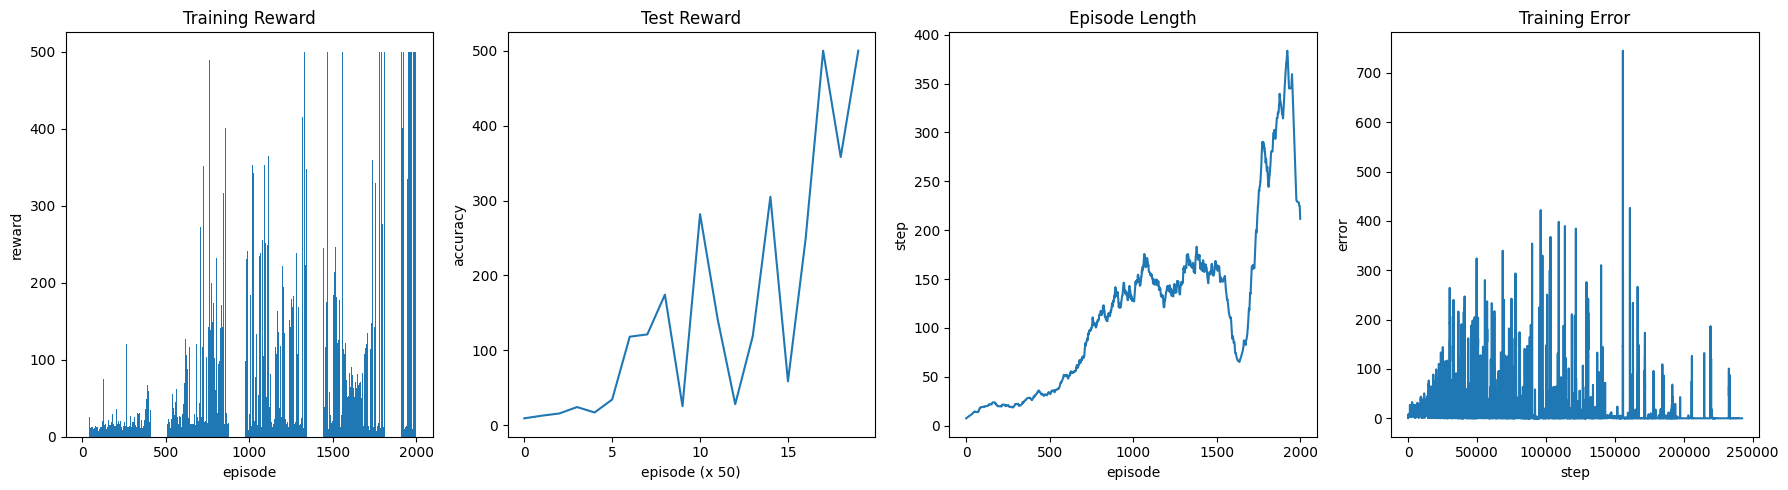

In [ ]:
rolling_length = 100
fig, axs = plt.subplots(ncols=4, figsize=(18, 5))
axs[0].set_title("Training Reward")
axs[0].set_xlabel('episode')
axs[0].set_ylabel('reward')
axs[0].bar(range(len(rewards)), rewards)

axs[1].set_title("Test Reward")
axs[1].set_xlabel('episode (x 50)')
axs[1].set_ylabel('accuracy')
axs[1].plot(range(len(accuracies)), accuracies)

axs[2].set_title("Episode Length")
axs[2].set_xlabel('episode')
axs[2].set_ylabel('step')
steps_moving_average = np.convolve(np.array(steps), np.ones(rolling_length), mode="same") / rolling_length
axs[2].plot(range(len(steps_moving_average)), steps_moving_average)

axs[3].set_title("Training Error")
axs[3].set_xlabel('step')
axs[3].set_ylabel('error')
training_error_moving_average = np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same") / rolling_length
axs[3].plot(range(len(training_error_moving_average)), training_error_moving_average)

plt.tight_layout()
plt.show()